In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms


In [ ]:
import xml.etree.ElementTree as ET


# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")


torch.cuda.is_available()
# 55 orange
# 53 apple
# 52 banana
Labels = {
    'orange': 1,
    'banana': 2,
    'apple': 3,

}

widthR, heightR =(600, 400)

class CustomDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        img_numpy = cv2.imread(str(file))[:, :, ::-1]
        height, width = img_numpy.shape[:2]
        k1=width/widthR 
        k2=height/heightR
        
        img = cv2.resize(img_numpy, (widthR, heightR))
        img = torch.from_numpy(img.astype('float32')).permute(2, 0, 1)
        img = img / 255.
        # print(img[None, ...].shape)
        return img, (k1,k2)

    # def getTargetandLabelTensor(self, target):
    #     npTarget = np.empty(0)
    #     npLabels = np.empty(0)
    #     for t in target:
    #         npLabels = np.append(npLabels, Labels[t['name']])
    #         npTarget = np.append(npTarget, np.array([t['xmin'], t['ymin'], t['xmax'], t['ymax']]))
    #     return torch.from_numpy(npTarget.astype('float32'))[None, ...], torch.from_numpy(npLabels.astype('int64'))[
    #         None, ...]

    def getTarget(self, xml, kt):
        tree = ET.parse(xml)
        tree.findall('object')
        boxes = []
        labels = []
        for obj in tree.findall('object'):
            name = obj.find('name').text
            box = obj.find('bndbox')
            xmin = np.float(box.find('xmin').text)/kt[0]
            ymin = np.float(box.find('ymin').text)/kt[1]
            xmax = np.float(box.find('xmax').text)/kt[0]
            ymax = np.float(box.find('ymax').text)/kt[1]
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(Labels[name])
        d = {}
        d ["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        d ["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        return d

    def __getitem__(self, index):
        # print(self.files[index])
        img,kt = self.load_sample(self.files[index])
        targets = self.getTarget(str(self.files[index]).replace('jpg', 'xml'), kt) 
        # print(targets["boxes"])       
        if self.mode == 'train':
            return img, targets
        elif self.mode == 'val':

            return img, targets
        else:
            return img

In [ ]:
def set_parameter_requires_grad(model):
  for param in model.parameters():
      param.requires_grad = True
class CustomFasterRCCN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()

        self.model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()
        # get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features 
        # replace the pre-trained head with a new one
        self.model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes).cuda()
        set_parameter_requires_grad(self.model_ft.roi_heads.box_predictor)

    def forward(self, img, target):        

        logits = self.model_ft(img, target)
        return logits
def get_object_detection_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).cuda()
 
    return model

In [ ]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def getMask(matr):
    # print("\n")
    # print(matr)
    tmax = matr.max(-1, keepdim=True)[0]
    return matr.ge(tmax)  # greater or equal


def get_metric(predict, valid_data):
    FN = 0
    FP = 0
    TP = 0
    val=list(zip(valid_data["boxes"], valid_data["labels"]))
    orangeVal = list(filter(lambda x: x[1] == Labels['orange'],val))
    bananaVal = list(filter(lambda x: x[1] == Labels['banana'], val))
    appleVal = list(filter(lambda x: x[1] == Labels['apple'], val))
    # print("\n")
    # print(orangeVal)
    # print("\n")
    # print(bananaVal)
    # print("\n")
    # print(appleVal)
    # print("\n")
    pred = list(zip(predict["boxes"], predict["labels"], predict["scores"]))
    pred = list(filter(lambda x: x[2] > 0.15, pred))
    orangePred = list(filter(lambda x: x[1] == Labels['orange'], pred))
    bananaPred = list(filter(lambda x: x[1] == Labels['banana'], pred))
    applePred = list(filter(lambda x: x[1] == Labels['apple'], pred))

    orangeMtr = torch.Tensor(len(orangeVal), len(orangePred))
    bananaMtr = torch.Tensor(len(bananaVal), len(bananaPred))
    appleMtr = torch.Tensor(len(appleVal), len(applePred))

    if len(orangePred) < len(orangeVal):
        FN += len(orangeVal) - len(orangePred)
    if len(bananaPred) < len(bananaVal):
        FN += len(bananaVal) - len(bananaPred)
    if len(applePred) < len(appleVal):
        FN += len(appleVal) - len(applePred)

    for i in range(len(orangeVal)):
        for j in range(len(orangePred)):
            orangeMtr[i, j] = iou(orangeVal[i][0], orangePred[j][0])

    for i in range(len(bananaVal)):
        for j in range(len(bananaPred)):
            bananaMtr[i, j] = iou(bananaVal[i][0], bananaPred[j][0])

    for i in range(len(appleVal)):
        for j in range(len(applePred)):
            appleMtr[i, j] = iou(appleVal[i][0], applePred[j][0])

    if len(orangeVal)>0 and len(orangePred)>0:
        TP += torch.sum(orangeMtr > 0.5)
        FP += torch.sum(orangeMtr < 0.5)
    if len(bananaVal)>0 and len(bananaPred)>0:
        TP += torch.sum( bananaMtr > 0.5)
        FP += torch.sum(bananaMtr < 0.5)
    if len(appleVal)>0 and len(applePred)>0:
        TP += torch.sum( appleMtr > 0.5)
        FP +=torch.sum(appleMtr < 0.5)
    return TP, FP, FN

def metric_batch(predict, valid_data):
    TP, FP, FN = 0., 0., 0.
    if len(predict) != len(valid_data):
        raise Exception('Wrong batch leng')
    lenArr = len(valid_data)
    for i in range(lenArr):
        tp, fp, fn = get_metric(predict[i], valid_data[i])
        TP += tp
        FP += fp
        FN += fn
    return TP / lenArr, FP / lenArr, FN / lenArr

def fit_epoch(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    i=0
    for img, targets in train_loader:
        i += 1
        # print(img[0].shape)
        img = list(img.to(DEVICE) for img in img)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()

        loss_dict = model(img,targets)
        # print("\nloss_dict")
        # print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        loss = losses.item()/len(loss_dict)  
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        # print(f'Iteration: {i}/{len(train_loader)}, Loss: {loss}')
        running_loss += loss           
    train_loss = running_loss / i
    return train_loss

def eval_epoch(model, val_loader):
    model.eval()
    recallSum = 0.0
    precisionSum = 0.0
    i=0
    for img, targets in val_loader:
        i += 1
        img = list(img.to(DEVICE) for img in img)
        # targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        # print(len(targets))
        with torch.set_grad_enabled(False):
            loss_dict = model(img)
            # print("loss_dict")
            # print(len(loss_dict))
            TP, FP, FN = metric_batch(loss_dict,targets)
            # print( "\nTP, FP, FN")
            # print( TP, FP, FN)
            recall = float(TP/(TP+FN))
            precision = float(TP/(TP+FP))
            recallSum+= recall
            precisionSum+=precision
            # print(f'Iteration: {i}/{len(val_loader)}, recall: {recall},precision: {precision} ')
    acc_recall=recallSum/i
    acc_precision=precisionSum/i
    return  acc_recall, acc_precision

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

def train(train_files, val_files, model, epochs, batch_size, l_r):

    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_loader = torch.utils.data.DataLoader(train_files, batch_size=batch_size,
                                          shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(train_files, batch_size=batch_size,
                                          shuffle=False, num_workers=2, collate_fn=collate_fn)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    acc_recall {acc_recall:0.4f} acc_precision {acc_precision:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # params = [p for p in model.parameters() if p.requires_grad]
        opt = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        # criterion = nn.CrossEntropyLoss()
        # для уменьшения lr каждую эпоху в два раза
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, opt)
            # print("loss", train_loss)            
            acc_recall, acc_precision = eval_epoch(model, val_loader)
            acc=(acc_recall+acc_precision)/2
            if acc > best_acc:
              best_acc = acc
              best_model_wts = model.state_dict()
            history.append((train_loss,acc_recall,  acc_precision))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           acc_recall=acc_recall, acc_precision=acc_precision))
            scheduler.step()
            # для сохранения чекпоинтов на всякий случай
            # torch.save(model, r"/content/drive/My Drive/rrcnn_" + str(epoch) + ".pkl")
           
    torch.save(best_model_wts, "/content/drive/My Drive/rrcnn_" + str(best_acc) + ".pth")         
    return history

In [ ]:
TRAIN_DIR = Path('/content/drive/My Drive/fruits/train_zip')
TEST_DIR = Path('/content/drive/My Drive/fruits/test_zip')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25)

val_dataset = CustomDataset(val_files, mode='val')
    
train_dataset = CustomDataset(train_files, mode='train')

net= torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=4, pretrained_backbone=True).to(DEVICE)
# net= torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
    

history = train(train_dataset, val_dataset, model=net, epochs=12, batch_size=4, l_r = 0.0001)

train_loss,acc_recall,  acc_precision = zip(*history)

epoch:   8%|▊         | 1/12 [01:20<14:42, 80.20s/it]


Epoch 001 train_loss: 0.1626     acc_recall 0.9637 acc_precision 0.0876


epoch:  17%|█▋        | 2/12 [02:37<13:14, 79.45s/it]


Epoch 002 train_loss: 0.0825     acc_recall 0.8212 acc_precision 0.1737


epoch:  25%|██▌       | 3/12 [03:55<11:50, 78.96s/it]


Epoch 003 train_loss: 0.0786     acc_recall 0.9259 acc_precision 0.1479


epoch:  33%|███▎      | 4/12 [05:13<10:29, 78.65s/it]


Epoch 004 train_loss: 0.0780     acc_recall 0.9337 acc_precision 0.1438


epoch:  42%|████▏     | 5/12 [06:30<09:07, 78.25s/it]


Epoch 005 train_loss: 0.0782     acc_recall 0.9467 acc_precision 0.1681


epoch:  50%|█████     | 6/12 [07:48<07:48, 78.11s/it]


Epoch 006 train_loss: 0.0785     acc_recall 0.9523 acc_precision 0.1467


epoch:  58%|█████▊    | 7/12 [09:06<06:29, 78.00s/it]


Epoch 007 train_loss: 0.0785     acc_recall 0.9565 acc_precision 0.1443


epoch:  67%|██████▋   | 8/12 [10:24<05:11, 77.96s/it]


Epoch 008 train_loss: 0.0783     acc_recall 0.9601 acc_precision 0.1471


epoch:  75%|███████▌  | 9/12 [11:42<03:53, 77.98s/it]


Epoch 009 train_loss: 0.0784     acc_recall 0.9595 acc_precision 0.1463


epoch:  83%|████████▎ | 10/12 [13:00<02:35, 77.92s/it]


Epoch 010 train_loss: 0.0787     acc_recall 0.9584 acc_precision 0.1440


epoch:  92%|█████████▏| 11/12 [14:17<01:17, 77.89s/it]


Epoch 011 train_loss: 0.0786     acc_recall 0.9625 acc_precision 0.1441


epoch: 100%|██████████| 12/12 [15:36<00:00, 78.00s/it]



Epoch 012 train_loss: 0.0791     acc_recall 0.9598 acc_precision 0.1444


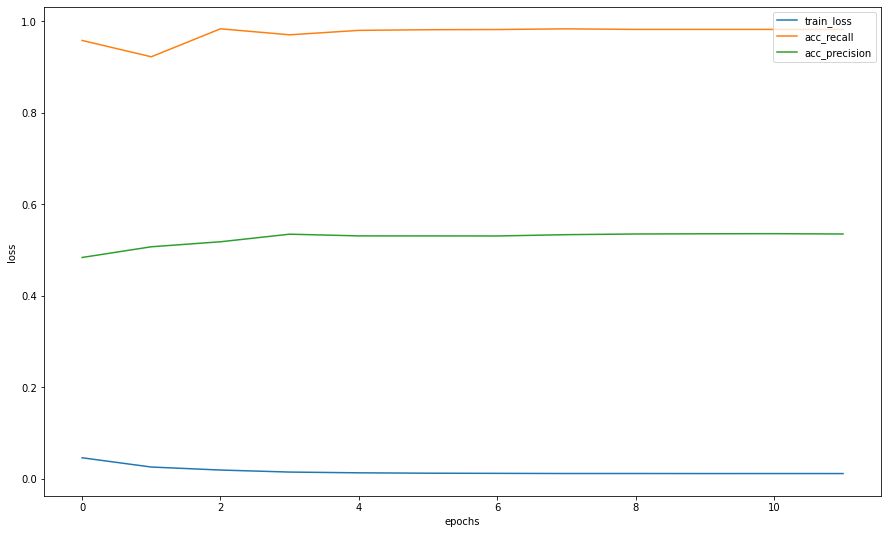

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(acc_recall, label="acc_recall")
plt.plot(acc_precision, label="acc_precision")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


[{'boxes': tensor([[123.1679, 238.5279, 351.7195, 442.6459],
        [325.4459, 231.3774, 560.3345, 438.2763],
        [519.6236, 313.7616, 656.9203, 465.7718],
        [259.9305, 353.2195, 400.0131, 481.2553],
        [236.3758,  52.6160, 423.5948, 295.9740],
        [383.4018, 353.6672, 549.7746, 497.9485],
        [533.9532, 303.7775, 653.3807, 401.1404],
        [325.2231, 222.9973, 549.5067, 451.0106]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([55, 55, 55, 55, 53, 55, 55, 52], device='cuda:0'), 'scores': tensor([0.9995, 0.9790, 0.9665, 0.9659, 0.9375, 0.7075, 0.3864, 0.3144],
       device='cuda:0', grad_fn=<IndexBackward>)}]
(535, 800, 3)


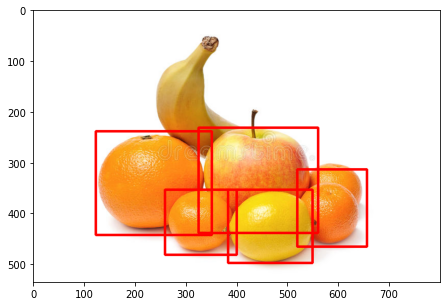

In [ ]:
def plot_preds(numpy_img, preds):
  boxes = preds['boxes'].cpu().detach().numpy()
  for box in boxes:
    numpy_img = cv2.rectangle(
        numpy_img, 
        (box[0],box[1]),
        (box[2],box[3]), 
        255,
        3
    )
  return numpy_img.get()

model = net.eval().cuda()
img_numpy = cv2.imread('/content/drive/My Drive/fruits/test_zip/test/mixed_21.jpg')[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
img = img / 255.
# print(img.shape)

predictions = model(img[None,...].cuda())
print(predictions)
# 55 orange
# 53 apple
# 52 banana
CONF_THRESH = 0.4
boxes = predictions[0]['boxes'][(predictions[0]['scores'] > CONF_THRESH) & (predictions[0]['labels'] == 55) ]
boxes_dict = {}
boxes_dict['boxes'] = boxes

img_with_boxes = plot_preds(img_numpy, boxes_dict)
print(img_with_boxes.shape)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_with_boxes.astype('uint'));